## libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
sys.path.insert(0, os.path.abspath('../palin/python'))

In [4]:
### rpy2
import sys
sys.executable
import rpy2
print(rpy2.__version__)
import os
os.environ['PATH'] = r'C:\Program Files\R\R-4.2.1\bin\x64'
os.environ['R_HOME'] = r'C:\Program Files\R\R-4.2.1' #path to your R installation
os.environ['R_USER'] = r'C:\Users\aynaz.adlzarrabi\Anaconda3\Lib\site-packages\rpy2' #path depends on where you installed Python. Mine is the Anaconda distribution
os.environ['R_LIBS_USER'] = r'C:\Program Files\R\R-4.2.1\library'
import rpy2.situation
for row in rpy2.situation.iter_info():
    print(row)
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
base = importr('base')
utils = importr('utils')
#%load_ext rpy2.ipython

from scipy.stats import mannwhitneyu, probplot, shapiro,chi2_contingency, kruskal
from pymer4.models import Lm

3.5.6
rpy2 version:
3.5.6
Python version:
3.8.3 (tags/v3.8.3:6f8c832, May 13 2020, 22:37:02) [MSC v.1924 64 bit (AMD64)]
Looking for R's HOME:
    Environment variable R_HOME: C:\Program Files\R\R-4.2.1
    InstallPath in the registry: C:\Program Files\R\R-4.3.2
    Environment variable R_USER: C:\Users\aynaz.adlzarrabi\Anaconda3\Lib\site-packages\rpy2
    Environment variable R_LIBS_USER: C:\Program Files\R\R-4.2.1\library
R version:
    In the PATH: R version 4.2.1 (2022-06-23 ucrt) -- "Funny-Looking Kid"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:


In [5]:
#from palin.simulation import Experiment
from palin.simulation.experiment import Experiment
from palin.simulation.analyser import Analyser
from palin.simulation.experiments.simple_experiment import SimpleExperiment
from palin.simulation.experiments.double_pass_experiment import DoublePassExperiment
from palin.simulation.trial import Int2Trial, Int1Trial 
from palin.simulation.observers.linear_observer import LinearObserver
from palin.simulation.analysers.kernel_distance import KernelDistance
from palin.simulation.analysers.internal_noise_value import InternalNoiseValue
from palin.kernels.classification_images import ClassificationImage
from palin.internal_noise.double_pass import DoublePass
from palin.internal_noise.intercept_method import InterceptMethod
from palin.simulation.simulation import Simulation as Sim
from palin.simulation.analysers.agreement_statistics import AgreementStatistics
from palin.internal_noise.agreement_method import AgreementMethod
from palin.internal_noise.distance_method import DistanceMethod
from palin.kernels.glm_kernel import GLMKernel
from palin.internal_noise.glm_method import GLMMethod


# Three new algorithms to estimate observer internal noise without double-pass measurements

&copy; Aynaz Adl Zarrabi, Jean-Julien Aucouturier, Ladislas Nalborczyk, Marie Villain

## Methods

### Consistency methods

#### Forward and inverse models

- The ideal observer model provides a generative model by which one can simulate the responses given by an observer with a given kernel and internal noise level, to arbitrary stimuli.  
- From these responses, one can evaluate a probability of agreement between duplicated trials (forward model). This model is stochastic: for a given observer, and a given experiment, responses have stochasticity because of internal noise realizations, and so does probability of agreement 
- the task of internal noise estimation from a real observer's response is the inverse model: from an observation of probability of agreement, find the most plausible internal noise level (hidden variable) that would forward-generate this probability
- to extend to the case where observers are biased (i.e a non null response criteria), one can also observe probability of answering the first interval (in a 2AFC design). In which case the forward model maps two hidden variables (internal noise and criteria) to two observations (probability of agreement, and probability of first interval)
- to deal with stochasticity, we compute the expected values of the observations (prob_agree, prob_int1) over several realizations of the same simulated experiment (forward model), and therefore aim to estimate the internal noise and criteria for which the observed probabilities are closest to their expected values
- a typical practical implementation of this procedure is to simulate observers with an arbitrary kernel (ex. a simple scalar) and a grid of internal noise and criteria values, encountering a single experiment for several runs (ex. 100 or 1000), compute the average corresponding probabilities for each internal noise and criteria; store this as a lookup table; then given a real observation of probabilities for a real observer, find the pair of internal noise and criteria that correspond to the closest pair of probabilities in the table. 

<Axes: xlabel='criteria', ylabel='internal_noise_std'>

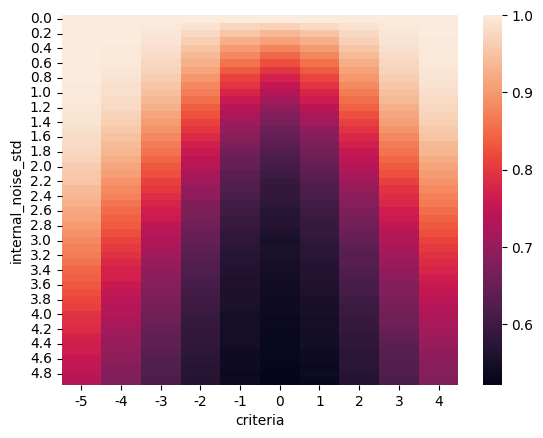

In [44]:
model_df = pd.read_csv('./agreement_model_large.csv')
model_df.internal_noise_std = model_df.internal_noise_std.map(lambda x: '%.1f'%x)

sns.heatmap(data=model_df.pivot(index="internal_noise_std", columns="criteria", values="prob_agree"))



<Axes: xlabel='criteria', ylabel='internal_noise_std'>

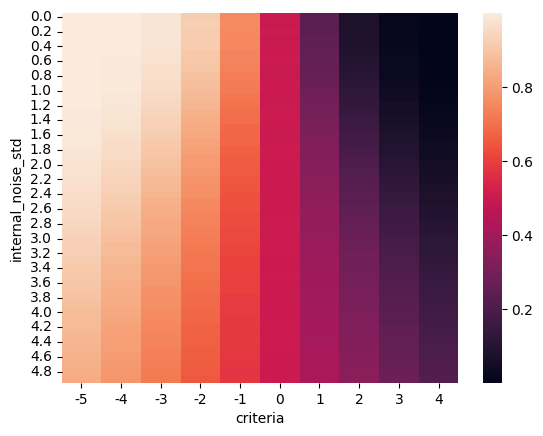

In [45]:
sns.heatmap(data=model_df.pivot(index="internal_noise_std", columns="criteria", values="prob_first"))

Rarely asked questions: 
- is it invertible ?
- effect of nb of runs, or nb of trials for the forward model
- effect of bounds (saturate at 5, or 10)
- difference between using actual experimental trials vs simulated experiment
- same n_trials of experiment, or as large as possible ?
- <mark> for Ladislas: </mark> comment utiliser DEOptim avec un système stochastique ?

In [97]:
model_df = pd.read_csv('./agreement_model_large.csv')
model_df.internal_noise_std = model_df.internal_noise_std.map(lambda x: '%.1f'%x)

model_df.pivot(index="prob_agree", columns="prob_first", values="internal_noise_std")

#sns.heatmap(data=model_df.pivot(index="prob_agree", columns="prob_first", values="internal_noise_std"))

prob_first,0.00191,0.00210,0.00226,0.00261,0.00290,0.00356,0.00429,0.00577,0.00696,0.00861,...,0.99846,0.99886,0.99933,0.99953,0.99961,0.99963,0.99966,0.99974,0.99975,0.99988
prob_agree,,,,,,,,,,,,,,,,,,,,,
0.52124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.52562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.52868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.52906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.53020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.99954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.4,NaN,NaN,NaN,NaN,NaN
0.99984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,NaN,NaN
0.99986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2,NaN


##### Effect of nb of runs & nb of trials

In short, as soon as you do n_runs > 1 (ex. 10), then the nb of trials (100,500,1000) doesn't have an impact that's larger than the inherent stochasticity of the system (i.e. any difference is < confidence interval over the runs). However, increasing both n trials and n runs increases the stability of the estimate. Globally, it tends to underestimate large (>3) internal noise values, exponentially so as we get closer to the bounds. 
-> **recommendation** we use 1000 trials, 20 runs in the following ?

In [79]:
for n_runs in [1, 10, 20]: 
    for n_trials in [100, 500, 1000]: 
        AgreementMethod.build_model(agreement_model_file = './model_trials_%d_runs_%d.csv'%(n_trials, n_runs),
                            internal_noise_range=np.arange(0,5,.1),
                            criteria_range=np.arange(-5,5,.5), 
                            n_repeated_trials=n_trials, 
                            n_runs=n_runs) 

Building double-pass model


100%|██████████| 1000/1000 [00:35<00:00, 28.40it/s]


Building double-pass model


100%|██████████| 1000/1000 [03:47<00:00,  4.40it/s]


Building double-pass model


100%|██████████| 1000/1000 [07:25<00:00,  2.25it/s]


Building double-pass model


100%|██████████| 10000/10000 [07:30<00:00, 22.18it/s]


Building double-pass model


100%|██████████| 10000/10000 [31:57<00:00,  5.22it/s]


Building double-pass model


100%|██████████| 10000/10000 [1:01:02<00:00,  2.73it/s]


Building double-pass model


100%|██████████| 20000/20000 [12:54<00:00, 25.84it/s]


Building double-pass model


100%|██████████| 20000/20000 [1:01:20<00:00,  5.43it/s]


Building double-pass model


100%|██████████| 20000/20000 [2:12:16<00:00,  2.52it/s]  


In [69]:
def parse_model_file_name(file_name):
    tokens = os.path.splitext(file_name)[0].split('_')
    return tokens[2], tokens[4]

parse_model_file_name('./model_trials_10_runs_20.csv')

('10', '20')

In [80]:
models = []
for n_runs in [1, 10, 20]: 
    for n_trials in [100, 500, 1000]: 
        models.append('./model_trials_%d_runs_%d.csv'%(n_trials, n_runs))
        
observer_params = {'kernel':['random'],
                   'internal_noise_std':np.arange(0,5.1,0.1), 
                  'criteria':[0]}
experiment_params = {'n_trials':[100], 
                     'n_repeated':[100],
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [100]}
analyser_params = {'internal_noise_extractor':[DoublePass],
                   'agreement_model_file':models}        
                   
sim = Sim(DoublePassExperiment, experiment_params, 
          LinearObserver, observer_params, 
          InternalNoiseValue, analyser_params)
sim_df = sim.run_all(n_runs=100)

sim_df['n_trials_model'] = sim_df.agreement_model_file.map(lambda x: parse_model_file_name(x)[0])
sim_df['n_runs_model'] = sim_df.agreement_model_file.map(lambda x: parse_model_file_name(x)[1])

sim_df.to_csv('./sim_internal_noise.csv')


100%|██████████| 45900/45900 [32:15<00:00, 23.72it/s]


C:\Users\Aucouturier\AppData\Local\Temp\ipykernel_1744\2670732256.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


Text(0.5, 1.0, '1000 trials')

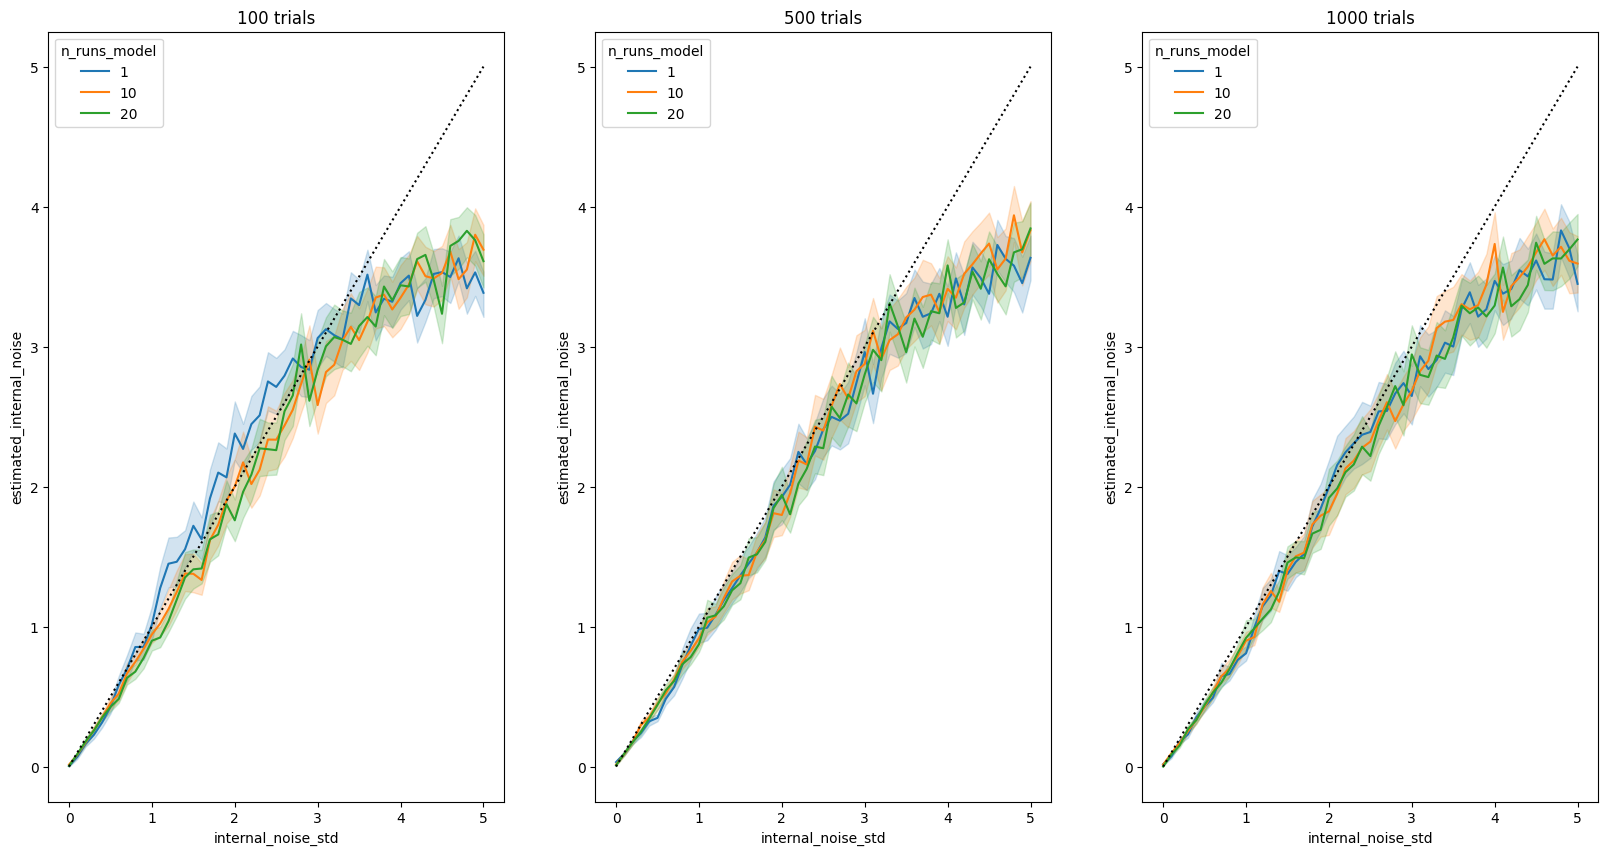

In [88]:
plt.subplots(figsize=(20,10))
plt.subplot(1,3,1)
sns.lineplot(data=sim_df[sim_df.n_trials_model=='100'], 
             x='internal_noise_std',
             y='estimated_internal_noise', hue='n_runs_model')
plt.plot([0,5],[0,5],'k:')
plt.title('100 trials')
plt.subplot(1,3,2)
sns.lineplot(data=sim_df[sim_df.n_trials_model=='500'], 
             x='internal_noise_std',
             y='estimated_internal_noise', hue='n_runs_model')
plt.plot([0,5],[0,5],'k:')
plt.title('500 trials')
plt.subplot(1,3,3)
sns.lineplot(data=sim_df[sim_df.n_trials_model=='1000'], 
             x='internal_noise_std',
             y='estimated_internal_noise', hue='n_runs_model')
plt.plot([0,5],[0,5],'k:')
plt.title('1000 trials')

C:\Users\Aucouturier\AppData\Local\Temp\ipykernel_1744\2703386166.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


Text(0.5, 1.0, '20 trials')

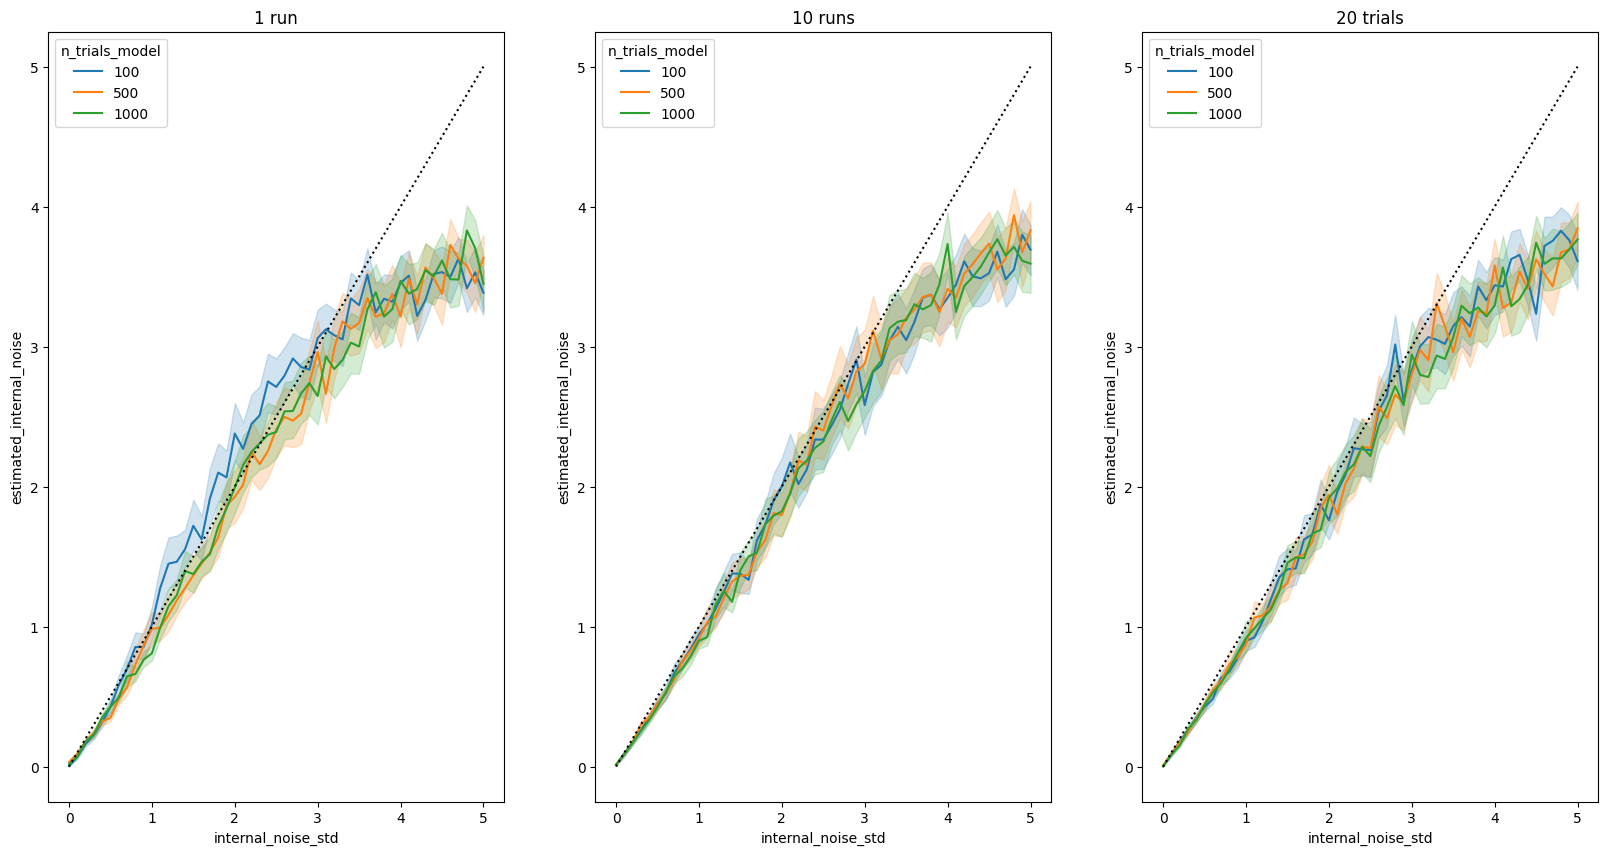

In [89]:
plt.subplots(figsize=(20,10))
plt.subplot(1,3,1)
sns.lineplot(data=sim_df[sim_df.n_runs_model=='1'], 
             x='internal_noise_std',
             y='estimated_internal_noise', hue='n_trials_model')
plt.plot([0,5],[0,5],'k:')
plt.title('1 run')
plt.subplot(1,3,2)
sns.lineplot(data=sim_df[sim_df.n_runs_model=='10'], 
             x='internal_noise_std',
             y='estimated_internal_noise', hue='n_trials_model')
plt.plot([0,5],[0,5],'k:')
plt.title('10 runs')
plt.subplot(1,3,3)
sns.lineplot(data=sim_df[sim_df.n_runs_model=='20'], 
             x='internal_noise_std',
             y='estimated_internal_noise', hue='n_trials_model')
plt.plot([0,5],[0,5],'k:')
plt.title('20 trials')

In [91]:
sim_df['internal_noise_error'] = sim_df.estimated_internal_noise - sim_df.internal_noise_std

C:\Users\Aucouturier\AppData\Local\Temp\ipykernel_1744\248889569.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


Text(0.5, 1.0, '1000 trials')

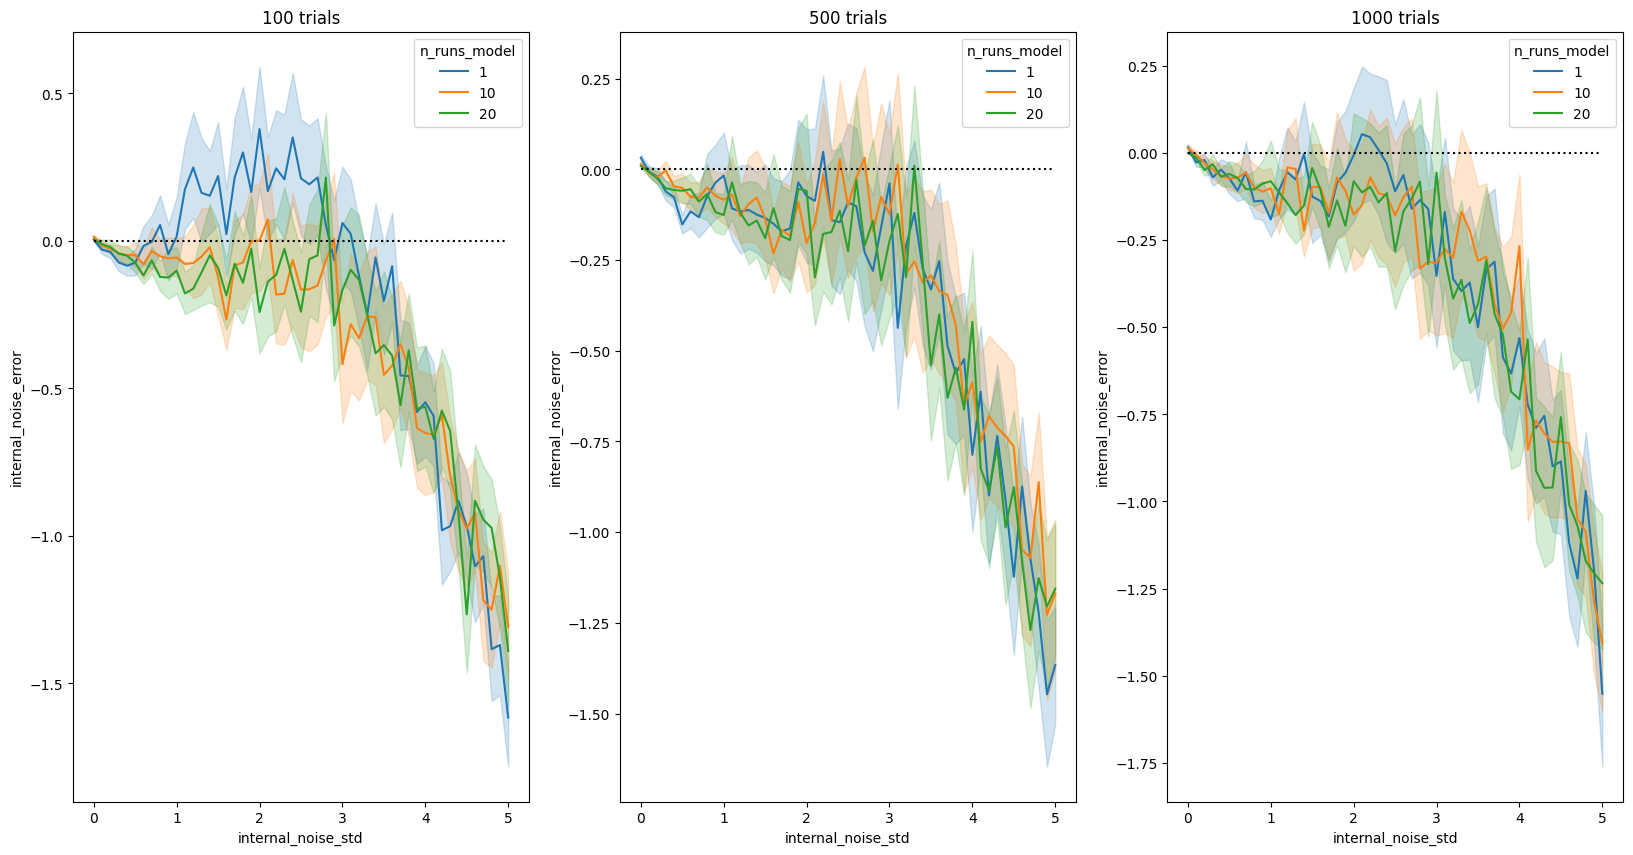

In [93]:
plt.subplots(figsize=(20,10))
plt.subplot(1,3,1)
sns.lineplot(data=sim_df[sim_df.n_trials_model=='100'], 
             x='internal_noise_std',
             y='internal_noise_error', hue='n_runs_model')
plt.plot([0,5],[0,0],'k:')
plt.title('100 trials')
plt.subplot(1,3,2)
sns.lineplot(data=sim_df[sim_df.n_trials_model=='500'], 
             x='internal_noise_std',
             y='internal_noise_error', hue='n_runs_model')
plt.plot([0,5],[0,0],'k:')
plt.title('500 trials')
plt.subplot(1,3,3)
sns.lineplot(data=sim_df[sim_df.n_trials_model=='1000'], 
             x='internal_noise_std',
             y='internal_noise_error', hue='n_runs_model')
plt.plot([0,5],[0,0],'k:')
plt.title('1000 trials')

C:\Users\Aucouturier\AppData\Local\Temp\ipykernel_1744\3905749762.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


Text(0.5, 1.0, '20 trials')

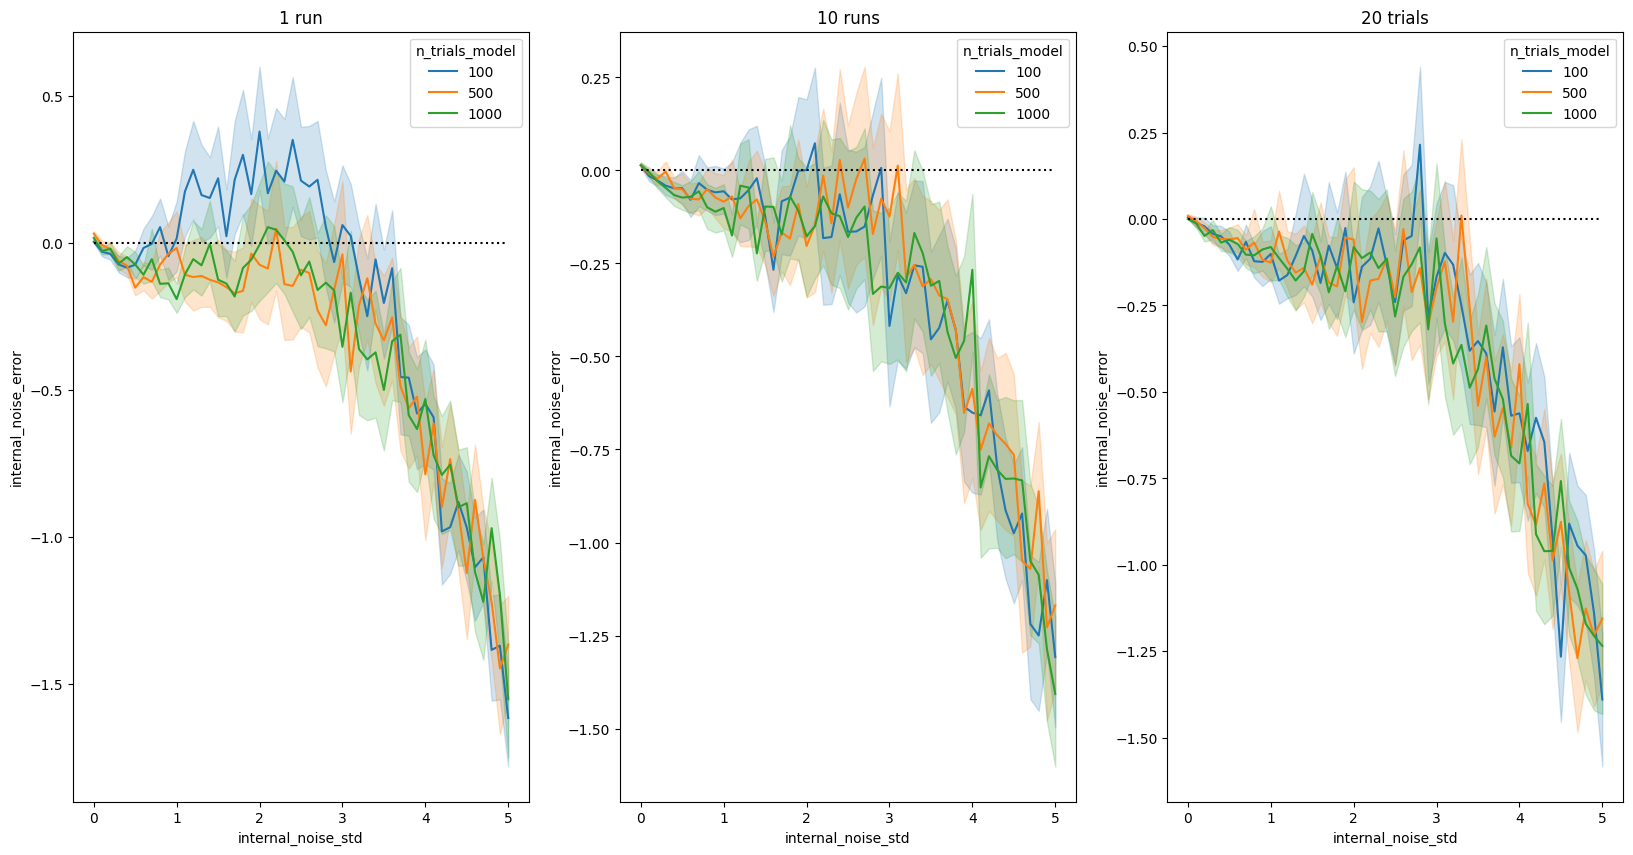

In [94]:
plt.subplots(figsize=(20,10))
plt.subplot(1,3,1)
sns.lineplot(data=sim_df[sim_df.n_runs_model=='1'], 
             x='internal_noise_std',
             y='internal_noise_error', hue='n_trials_model')
plt.plot([0,5],[0,0],'k:')
plt.title('1 run')
plt.subplot(1,3,2)
sns.lineplot(data=sim_df[sim_df.n_runs_model=='10'], 
             x='internal_noise_std',
             y='internal_noise_error', hue='n_trials_model')
plt.plot([0,5],[0,0],'k:')
plt.title('10 runs')
plt.subplot(1,3,3)
sns.lineplot(data=sim_df[sim_df.n_runs_model=='20'], 
             x='internal_noise_std',
             y='internal_noise_error', hue='n_trials_model')
plt.plot([0,5],[0,0],'k:')
plt.title('20 trials')

## Results

### Intercept Method

On choisit les meilleurs paramètres avec RMSE vs double pass p_agree

**Rôle of n_bins**

In [81]:
observer_params = {'kernel':['random'],
                   'internal_noise_std':np.arange(0,5.1,0.5), 
                  'criteria':[0]}
experiment_params = {'n_trials':[1000], 
                     'n_repeated':[1000],
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [100]}
analyser_params = {'internal_noise_extractor':[InterceptMethod, DoublePass],
                   'kernel_extractor':[ClassificationImage],
                  'bin_data':[True],
                   'n_bins':[10,50,100,200,300,400,500,1000,2000,3000, 5000, 10000],
                   'fit_method':['poly','glm']}        
                   
sim = Sim(DoublePassExperiment, experiment_params, 
          LinearObserver, observer_params, 
          AgreementStatistics, analyser_params)

sim_df = sim.run_all(n_runs=10)

sim_df.to_csv('3method_sim1.csv')

100%|██████████| 5280/5280 [1:59:29<00:00,  1.36s/it]   


C:\Users\Aucouturier\AppData\Local\Temp\ipykernel_17924\3191152187.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


(0.5, 1.1)

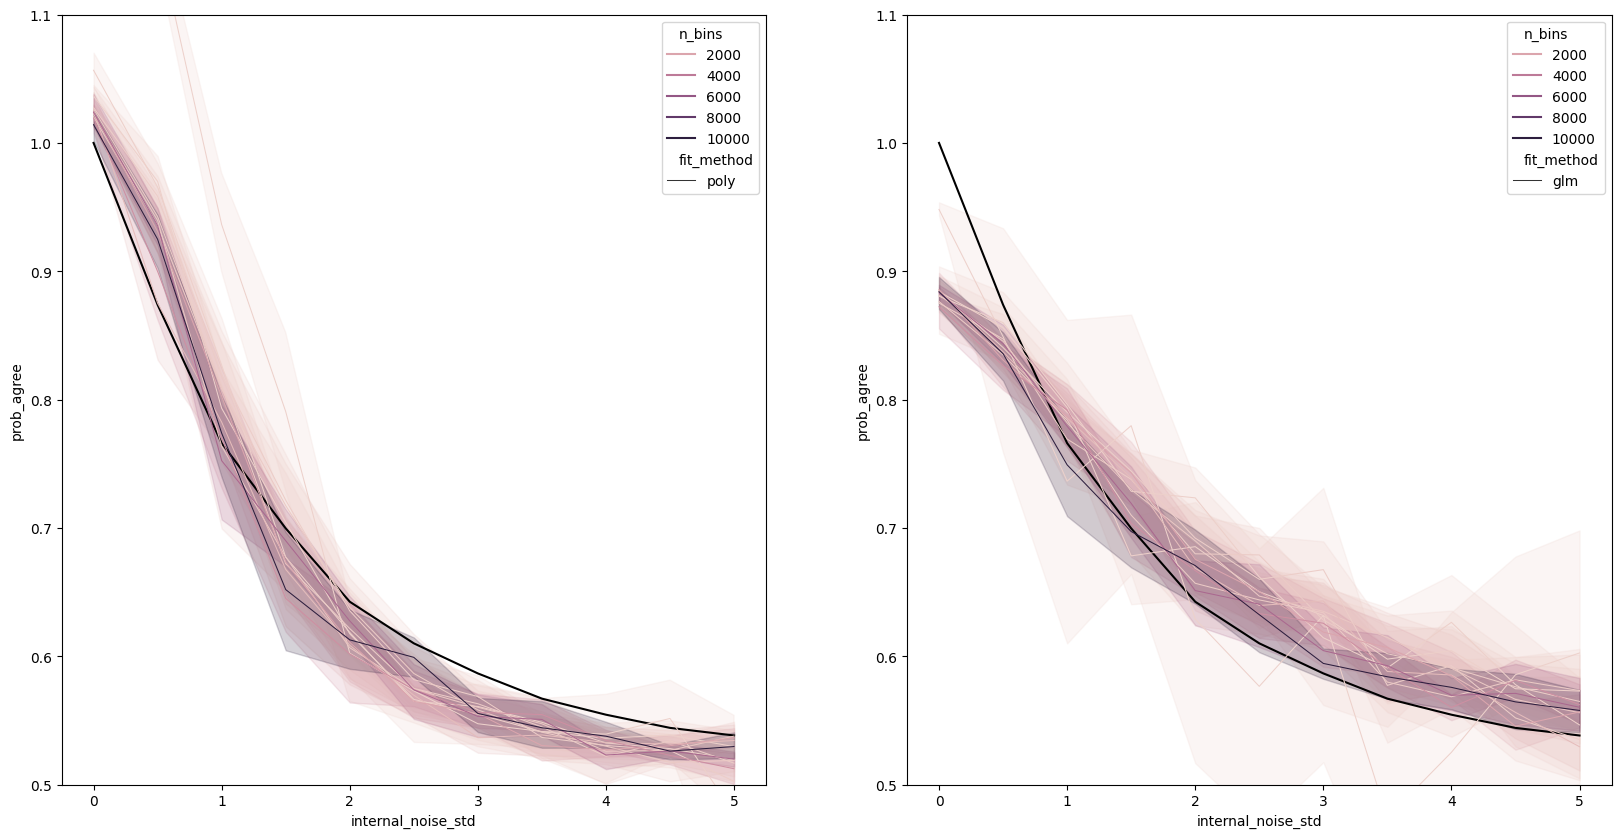

In [88]:
sim_df =pd.read_csv('3method_sim1.csv')

plt.subplots(figsize=(20,10))

plt.subplot(1,2,1)

sns.lineplot(data=sim_df[sim_df.internal_noise_extractor==DoublePass].groupby(['internal_noise_std'], 
                                                                              as_index=False).prob_agree.mean(), 
            x="internal_noise_std", 
            y='prob_agree',  color='black')

sns.lineplot(data=sim_df[(sim_df.internal_noise_extractor==InterceptMethod)], 
            x="internal_noise_std", 
            y='prob_agree', 
            hue='n_bins', 
             hue_order=[10,50,100,200,300,400,500],
                                     size='fit_method', size_order=['poly'])

plt.ylim([0.5,1.1])
plt.subplot(1,2,2)

sns.lineplot(data=sim_df[sim_df.internal_noise_extractor==DoublePass].groupby(['internal_noise_std'], 
                                                                              as_index=False).prob_agree.mean(), 
            x="internal_noise_std", 
            y='prob_agree',  color='black')

                       
sns.lineplot(data=sim_df[(sim_df.internal_noise_extractor==InterceptMethod)], 
            x="internal_noise_std", 
            y='prob_agree', 
            hue='n_bins', hue_order=[10,50,100,200,300,400,500],size='fit_method', size_order=['glm'])
plt.ylim([0.5,1.1])


POLY
GLM


C:\Users\Aucouturier\AppData\Local\Temp\ipykernel_17924\2339678864.py:20: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  test_data = test_data.join(ground_truth, on='internal_noise_std', rsuffix='_gt')
C:\Users\Aucouturier\AppData\Local\Temp\ipykernel_17924\2339678864.py:20: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  test_data = test_data.join(ground_truth, on='internal_noise_std', rsuffix='_gt')
C:\Users\Aucouturier\AppData\Local\Temp\ipykernel_17924\2339678864.py:20: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  test_data = test_data.join(ground_truth, on='internal_noise_std', rsuffix='_gt')
C:\Users\Aucouturier\AppData\Local\Temp\ipykernel_17924\2339678864.py:20: UserWarning: You are merging on int and float columns where the float values are not equal to t

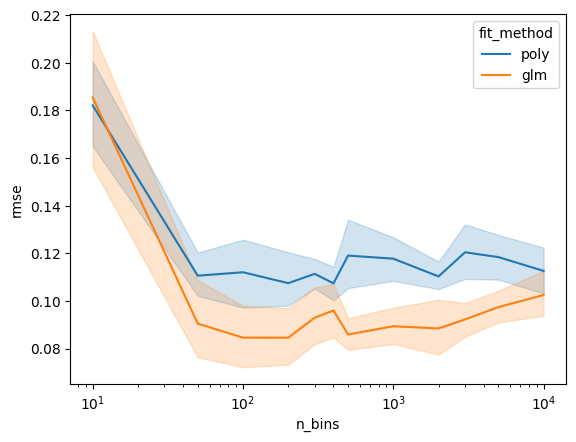

In [175]:
sim_df =pd.read_csv('3method_sim1.csv')

# compute RMSE vs dblepass
ground_truth = sim_df[sim_df.internal_noise_extractor==str(DoublePass)].groupby(['internal_noise_std'], 
                                                                              as_index=False).prob_agree.mean()

n_bins = []
rmses = []
runs=[]
methods=[]

for fit_method in ['poly','glm']: 
    print('%s'%fit_method.upper())
    for n_bin in [10,50,100,200,300,400,500,1000,2000,3000, 5000, 10000]:
        test_data = sim_df[(sim_df.internal_noise_extractor==str(InterceptMethod))
                               &(sim_df.n_bins == n_bin)
                               &(sim_df.fit_method==fit_method)].groupby(['internal_noise_std','run'],
                                                      as_index=False).prob_agree.mean()
        
        test_data = test_data.join(ground_truth, on='internal_noise_std', rsuffix='_gt')
        
        for n_run in sim_df.run.unique(): 
            rmse = np.sqrt((test_data[test_data.run==n_run].prob_agree - test_data.prob_agree_gt).pow(2).mean())
                        
            #print('n_bins %d (%d): %.3f'%(n_bin,n_run,rmse))
            n_bins.append(n_bin)
            rmses.append(rmse)
            runs.append(n_run)
            methods.append(fit_method)
            
data_df = pd.DataFrame.from_dict({'n_bins':n_bins,'rmse':rmses, 'run':runs, 'fit_method':methods})
sns.lineplot(data=data_df,
            x='n_bins', y='rmse', hue='fit_method')
        
plt.xscale('log')

**Comparison of binning vs non-binned**

In [94]:
observer_params = {'kernel':['random'],
                   'internal_noise_std':np.arange(0,5.1,0.5), 
                  'criteria':[0]}
experiment_params = {'n_trials':[1000], 
                     'n_repeated':[1000],
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [100]}
analyser_params = {'internal_noise_extractor':[InterceptMethod, DoublePass],
                   'kernel_extractor':[ClassificationImage],
                  'bin_data':[True,False],
                   'n_bins':[100],
                   'fit_method':['poly','glm']}        
                   
sim = Sim(DoublePassExperiment, experiment_params, 
          LinearObserver, observer_params, 
          AgreementStatistics, analyser_params)

sim_df = sim.run_all(n_runs=10)
sim_df.to_csv('3method_sim2.csv')

100%|██████████| 880/880 [20:53<00:00,  1.42s/it]  


C:\Users\Aucouturier\AppData\Local\Temp\ipykernel_17924\1383503135.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


(0.5, 1.1)

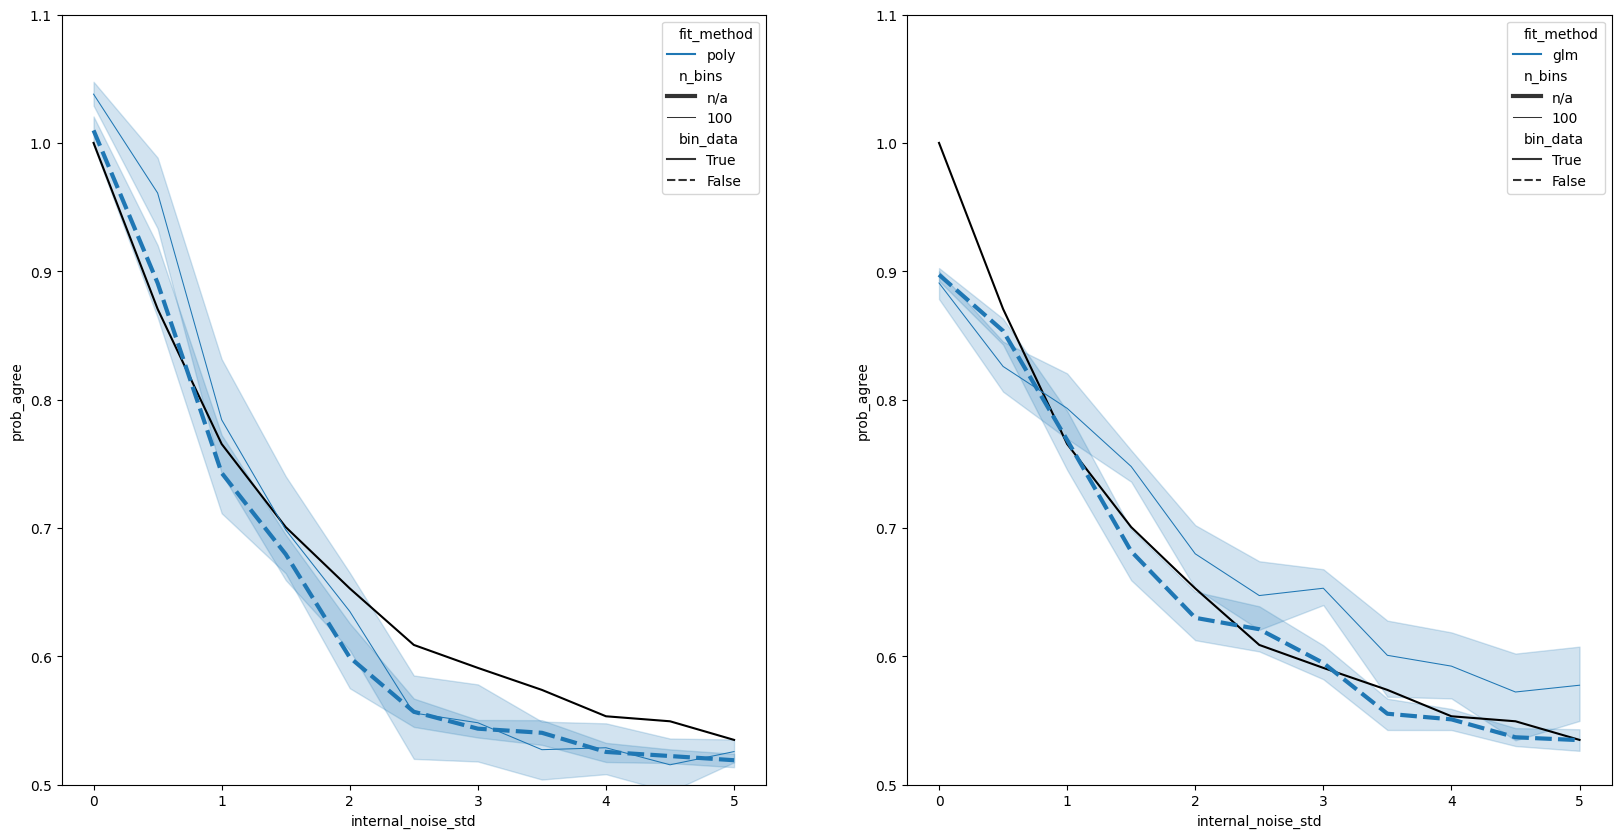

In [171]:
sim_df =pd.read_csv('3method_sim2.csv')

plt.subplots(figsize=(20,10))

plt.subplot(1,2,1)

sns.lineplot(data=sim_df[sim_df.internal_noise_extractor==str(DoublePass)].groupby(['internal_noise_std'], 
                                                                              as_index=False).prob_agree.mean(), 
            x="internal_noise_std", 
            y='prob_agree',  color='black')

test_data = sim_df[(sim_df.internal_noise_extractor==str(InterceptMethod))
                   &(sim_df.bin_data==False)].groupby(['internal_noise_std','run','fit_method', 'bin_data'],
                                                      as_index=False).prob_agree.mean()
test_data['n_bins'] = 'n/a'
test_data = pd.concat([test_data, sim_df[(sim_df.internal_noise_extractor==str(InterceptMethod))
                                         &(sim_df.bin_data==True)]])
                       
sns.lineplot(data=test_data, 
            x="internal_noise_std", 
            y='prob_agree', 
            hue='fit_method', hue_order = ['poly'], size='n_bins', #size_order=['n/a',100,50],
             style='bin_data', style_order=[True,False])

plt.ylim([0.5,1.1])
plt.subplot(1,2,2)

sns.lineplot(data=sim_df[sim_df.internal_noise_extractor==str(DoublePass)].groupby(['internal_noise_std'], 
                                                                              as_index=False).prob_agree.mean(), 
            x="internal_noise_std", 
            y='prob_agree',  color='black')

test_data = sim_df[(sim_df.internal_noise_extractor==str(InterceptMethod))
                   &(sim_df.bin_data==False)].groupby(['internal_noise_std','run','fit_method', 'bin_data'],
                                                      as_index=False).prob_agree.mean()
test_data['n_bins'] = 'n/a'
test_data = pd.concat([test_data, sim_df[(sim_df.internal_noise_extractor==str(InterceptMethod))
                                         &(sim_df.bin_data==True)]])
                       
sns.lineplot(data=test_data, 
            x="internal_noise_std", 
            y='prob_agree', 
            hue='fit_method', hue_order = ['glm'], size='n_bins', #size_order=['n/a',100,50], 
             style='bin_data', style_order=[True,False])

plt.ylim([0.5,1.1])


In [177]:
sim_df =pd.read_csv('3method_sim2.csv')

# compute RMSE vs dblepass
ground_truth = sim_df[sim_df.internal_noise_extractor==str(DoublePass)].groupby(['internal_noise_std'], 
                                                                              as_index=False).prob_agree.mean()
for fit_method in ['poly','glm']: 
    print('%s'%fit_method.upper())
    for bin_data in [True,False]:
        print('bin: %s'%bin_data)
        test_data = sim_df[(sim_df.internal_noise_extractor==str(InterceptMethod))
                               &(sim_df.bin_data==bin_data)
                               &(sim_df.fit_method==fit_method)].groupby(['internal_noise_std'],
                                                      as_index=False).prob_agree.mean()
        rmse = np.sqrt((test_data[test_data.internal_noise_std>1].sort_values(by='internal_noise_std').prob_agree
                            - ground_truth[ground_truth.internal_noise_std>1].sort_values(by='internal_noise_std').prob_agree).pow(2).mean())
                        
        print(' %.3f '%(rmse))
        

POLY
bin: True
 0.033 
bin: False
 0.037 
GLM
bin: True
 0.040 
bin: False
 0.014 


bins pas nécessaire, GLM meilleur pour IN > 1

### Distance method

In [182]:
observer_params = {'kernel':['random'],
                   'internal_noise_std':np.arange(0,5.1,0.5), 
                  'criteria':[0]}
experiment_params = {'n_trials':[1000], 
                     'n_repeated':[1000],
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [100]}
analyser_params = {'internal_noise_extractor':[DistanceMethod, DoublePass],
                   'kernel_extractor':[ClassificationImage],
                  'method':['accuracy'],
                   'trial_mask':['all','hit','cr'],
                   'weight_trials':[True,False]}        
                   
sim = Sim(DoublePassExperiment, experiment_params, 
          LinearObserver, observer_params, 
          AgreementStatistics, analyser_params)

sim_df = sim.run_all(n_runs=10)
sim_df.to_csv('3method_sim3.csv')

100%|██████████| 6120/6120 [25:53<00:00,  3.94it/s]  


<Axes: xlabel='internal_noise_std', ylabel='prob_agree'>

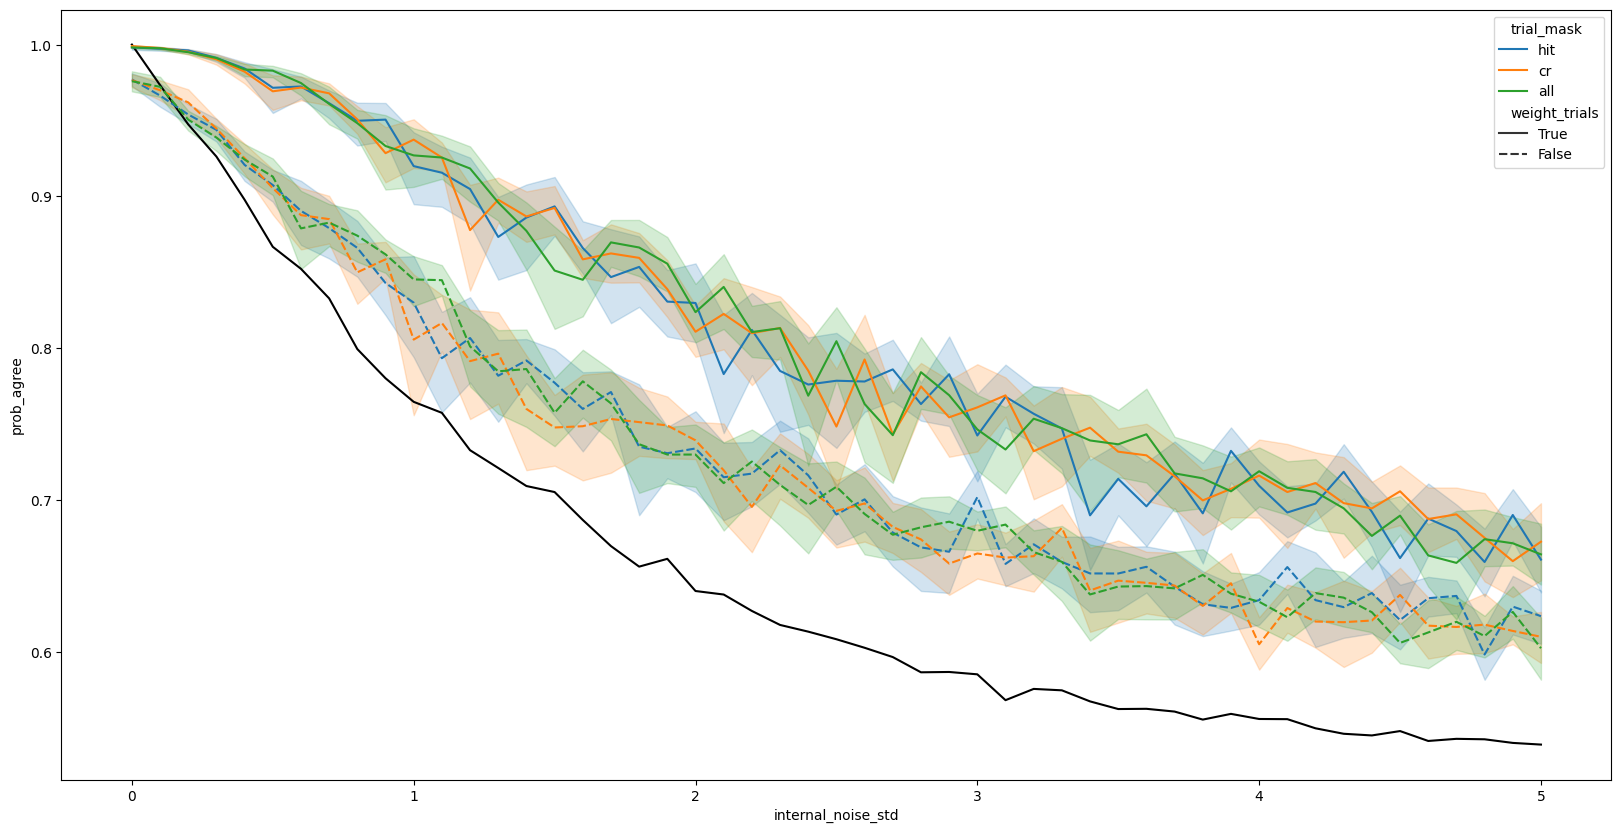

In [184]:
sim_df =pd.read_csv('3method_sim3.csv')

plt.subplots(figsize=(20,10))

sns.lineplot(data=sim_df[sim_df.internal_noise_extractor==str(DoublePass)].groupby(['internal_noise_std'], 
                                                                              as_index=False).prob_agree.mean(), 
            x="internal_noise_std", 
            y='prob_agree',  color='black')

test_data = sim_df[(sim_df.internal_noise_extractor==str(DistanceMethod))].groupby(['internal_noise_std','run',
                                                                               'trial_mask',
                                                                               'weight_trials'],
                                                      as_index=False).prob_agree.mean()
                       
sns.lineplot(data=test_data, 
            x="internal_noise_std", 
            y='prob_agree', 
            hue='trial_mask', hue_order = ['hit','cr','all'], 
             style='weight_trials', style_order=[True,False])



In [186]:
sim_df =pd.read_csv('3method_sim3.csv')

# compute RMSE vs dblepass
ground_truth = sim_df[sim_df.internal_noise_extractor==str(DoublePass)].groupby(['internal_noise_std'], 
                                                                              as_index=False).prob_agree.mean()
for trial_mask in ['hit','cr','all']: 
    print('%s'%trial_mask)
    for weight_trials in [True,False]:
        print('weight: %s'%weight_trials)
        test_data = sim_df[(sim_df.internal_noise_extractor==str(DistanceMethod))
                               &(sim_df.weight_trials==weight_trials)
                               &(sim_df.trial_mask==trial_mask)].groupby(['internal_noise_std','run'],
                                                      as_index=False).prob_agree.mean()
        rmse = np.sqrt((test_data.sort_values(by='internal_noise_std').prob_agree
                            - ground_truth.sort_values(by='internal_noise_std').prob_agree).pow(2).mean())
                        
        print(' %.3f '%(rmse))
        

hit
weight: True
 0.355 
weight: False
 0.311 
cr
weight: True
 0.354 
weight: False
 0.315 
all
weight: True
 0.354 
weight: False
 0.311 


ça fitte moins bien le prob agree mais ça ne veut pas dire que ça ne peut pas marcher mieux en lookup specifique

les non weighted est plus proche de prob agree, pas de différence all/hit/cr

### Model-based

Evaluer backend, link, agg mode, against true internal noise

<mark> attention GLM Method ne filtre pas les single_pass

d'abord construire les OLS

In [6]:
for agg_mode in ['min','mean','median', 'max', 'argmin', 'argmax', 'argmedian']: 
    for link in ['logit','probit']:
        for backend in ['python','rpy2']:
            GLMMethod.build_model(agg_mode = agg_mode, backend=backend, link=link)

  0%|          | 0/9690 [00:12<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
observer_params = {'kernel':['random'],
                   'internal_noise_std':np.arange(0,5.1,0.5), 
                  'criteria':[0]}
experiment_params = {'n_trials':[1000],
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [100]}
analyser_params = {'internal_noise_extractor':[GLMMethod],
                   'backend':['python','rpy2'],
                  'link':['logit','probit'],
                  'jitter':[0.01, 0.02, 0.05, 0.1, 0.15, 0.2],
                   'agg_mode':['min','mean','median', 'max', 'argmin', 'argmax', 'argmedian']}        
                   
sim = Sim(SimpleExperiment, experiment_params, 
          LinearObserver, observer_params, 
          InternalNoiseValue, analyser_params)

sim_df_glm = sim.run_all(n_runs=10)


100%|██████████| 18480/18480 [1:13:30<00:00,  4.19it/s]


In [ ]:
sim_df_glm.to_csv('3method_sim6.csv')
sim_df_glm =pd.read_csv('3method_sim6.csv')

In [ ]:
test_data = sim_df_glm[sim_df_glm.backend == 'rpy2'] \
    .groupby(['backend', 'agg_mode', 'link', 'internal_noise_std', 'run'], as_index=False) \
    .estimated_internal_noise.mean()

test_data['jitter'] = 'n/a'

test_data = pd.concat([test_data, sim_df_glm[sim_df_glm.backend == 'python']])

rmse_data = test_data.groupby(['backend', 'jitter', 'agg_mode', 'link'], as_index=False) \
    .apply(lambda group: pd.Series({
        'rmse': np.sqrt(((group.estimated_internal_noise - group.internal_noise_std) ** 2).mean())
    }))

# Step 4: Sort by RMSE
rmse_data = rmse_data.sort_values(by='rmse')
rmse_data.reset_index(drop=True, inplace=True)

rmse_data.head(30)

,backend,jitter,agg_mode,link,rmse
0,python,0.15,min,logit,0.680614
1,python,0.05,argmax,probit,0.780212
2,python,0.02,min,probit,0.787289
3,python,0.1,min,probit,0.806496
4,rpy2,n/a,median,probit,0.865134
5,python,0.05,argmax,logit,0.890501
6,rpy2,n/a,argmedian,probit,0.903161
7,python,0.05,min,probit,0.919422
8,python,0.1,min,logit,0.932970
9,python,0.2,min,probit,0.969186


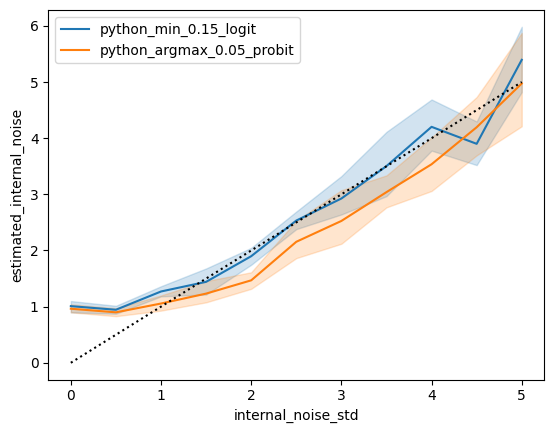

In [46]:
plt.plot(figsize=(20,10))

sns.lineplot(data=sim_df_glm[(sim_df_glm.backend=='python')&(sim_df_glm.agg_mode=='min')&(sim_df_glm.jitter==0.15)&(sim_df_glm.link=='logit')], 
            x="internal_noise_std", 
            y='estimated_internal_noise',label='python_min_0.15_logit')


sns.lineplot(data=sim_df_glm[(sim_df_glm.backend=='python')&(sim_df_glm.agg_mode=='argmax')&(sim_df_glm.jitter==0.05)&(sim_df_glm.link=='probit')], 
            x="internal_noise_std", 
            y='estimated_internal_noise',label='python_argmax_0.05_probit')

# sns.lineplot(data=sim_df_glm[(sim_df_glm.backend=='python')&(sim_df_glm.agg_mode=='min')&(sim_df_glm.jitter==0.02)&(sim_df_glm.link=='probit')], 
#             x="internal_noise_std", 
#             y='estimated_internal_noise',label='python_min_0.02_probit')

# sns.lineplot(data=sim_df_glm[(sim_df_glm.backend=='python')&(sim_df_glm.agg_mode=='min')&(sim_df_glm.jitter==0.1)&(sim_df_glm.link=='probit')], 
#             x="internal_noise_std", 
#             y='estimated_internal_noise',label='python_min_0.1_probit')

# sns.lineplot(data=sim_df_glm[(sim_df_glm.backend=='rpy2')&(sim_df_glm.agg_mode=='median')&(sim_df_glm.link=='probit')], 
#             x="internal_noise_std", 
#             y='estimated_internal_noise',label='rpy2_median_probit')



plt.plot([0,5],[0,5], 'k:')


Compare Python w/ jitter, with rpy2

In [49]:
observer_params = {'kernel':['random'],
                   'internal_noise_std':np.arange(0,5.1,0.5), 
                  'criteria':[0]}
experiment_params = {'n_trials':[1000],
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [100]}
analyser_params = {'internal_noise_extractor':[GLMMethod],
                   'backend':['python'],
                  'link':['logit','probit'],
                  'jitter':[0.01, 0.02, 0.05, 0.1, 0.15, 0.2],
                   'agg_mode':['min','mean','median', 'max', 'argmin', 'argmax', 'argmedian']}        
                   
sim = Sim(SimpleExperiment, experiment_params, 
          LinearObserver, observer_params, 
          InternalNoiseValue, analyser_params)

sim_df_glm2 = sim.run_all(n_runs=100)

100%|██████████| 92400/92400 [10:08<00:00, 151.86it/s]


In [92]:
sim_df_glm2.to_csv('3method_sim7.csv')

In [50]:
rmse_data2 = sim_df_glm2.groupby(['jitter', 'agg_mode', 'link'], as_index=False) \
    .apply(lambda group: pd.Series({
        'rmse': np.sqrt(((group.estimated_internal_noise - group.internal_noise_std) ** 2).mean())
    }))

# Step 4: Sort by RMSE
rmse_data2 = rmse_data2.sort_values(by='rmse')
rmse_data2.reset_index(drop=True, inplace=True)

rmse_data2.head(36)

,jitter,agg_mode,link,rmse
0,0.10,min,logit,1.050540
1,0.02,argmax,probit,1.076934
2,0.05,argmax,logit,1.085218
3,0.05,min,probit,1.087541
4,0.02,min,logit,1.104791
5,0.10,argmax,logit,1.125494
6,0.01,min,probit,1.129533
7,0.05,argmax,probit,1.132225
8,0.02,argmax,logit,1.150069
9,0.15,min,probit,1.155114


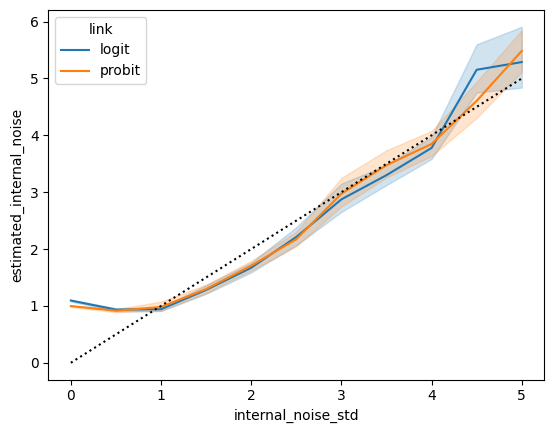

In [60]:
sns.lineplot(data=sim_df_glm2[(sim_df_glm2.agg_mode=='min')&(sim_df_glm2.jitter==0.05)], 
            x="internal_noise_std", 
            y='estimated_internal_noise',hue='link')
plt.plot([0,5],[0,5], 'k:')


In [63]:
observer_params = {'kernel':['random'],
                   'internal_noise_std':np.arange(0,5.1,0.1), 
                  'criteria':[0]}
experiment_params = {'n_trials':[1000,2000],
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [100]}
analyser_params = {'internal_noise_extractor':[GLMMethod],
                   'backend':['python'],
                  'link':['logit','probit'],
                  'jitter':[0.01, 0.02, 0.05, 0.1, 0.15, 0.2],
                   'agg_mode':['min', 'argmax']}        
                   
sim = Sim(SimpleExperiment, experiment_params, 
          LinearObserver, observer_params, 
          InternalNoiseValue, analyser_params)

sim_df_glm3 = sim.run_all(n_runs=10)

100%|██████████| 24480/24480 [03:34<00:00, 114.06it/s]


In [68]:
rmse_data3 = sim_df_glm3.groupby(['jitter', 'agg_mode','n_trials', 'link'], as_index=False) \
    .apply(lambda group: pd.Series({
        'rmse': np.sqrt(((group.estimated_internal_noise - group.internal_noise_std) ** 2).mean())
    }))

# Step 4: Sort by RMSE
rmse_data3 = rmse_data3.sort_values(by='rmse')
rmse_data3.reset_index(drop=True, inplace=True)

rmse_data3

,jitter,agg_mode,n_trials,link,rmse
0,0.10,min,2000,logit,0.828289
1,0.05,argmax,2000,probit,0.834456
2,0.15,min,2000,logit,0.847116
3,0.02,argmax,2000,logit,0.851792
4,0.02,min,2000,logit,0.877961
5,0.05,min,1000,probit,0.885355
6,0.05,argmax,1000,probit,0.891634
7,0.05,argmax,2000,logit,0.918528
8,0.02,min,2000,probit,0.963256
9,0.10,argmax,1000,logit,0.972831


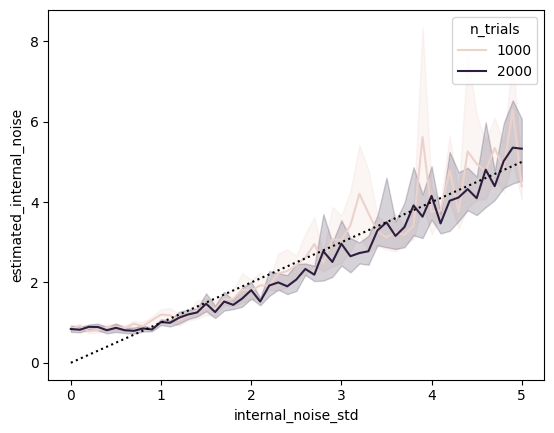

In [69]:
sns.lineplot(data=sim_df_glm3[(sim_df_glm3.agg_mode=='min')&(sim_df_glm3.jitter==0.10)&(sim_df_glm3.link=='logit')], 
            x="internal_noise_std", 
            y='estimated_internal_noise',hue='n_trials')
plt.plot([0,5],[0,5], 'k:')


### Comparison of all methods

Attention à comparer les méthodes à durée équivalente (cad 500+500 pour dble pass et 1000+* pour les autres)

<mark> attention GLM Method ne filtre pas les single_pass

Attention à bien construire des lookups entre 0 et 10 pour ne pas créer de sous-estimation

- Intercept: poly non bin, glm non bin
- Distance: weighted true et false, all
- GLM: rpy2, aggmode ? link ? 

In [70]:
InterceptMethod.build_model(agreement_model_file = './intercept_poly.csv',
                            internal_noise_range=np.arange(0,10,.1),
                            criteria_range=np.arange(-5,5,1),
                            n_repeated_trials=1000, 
                            n_runs=10, 
                            fit_method='poly',bin_data=False, kernel_extractor=ClassificationImage)

InterceptMethod.build_model(agreement_model_file = './intercept_glm.csv',
                            internal_noise_range=np.arange(0,10,.1),
                            criteria_range=np.arange(-5,5,1),
                            n_repeated_trials=1000, 
                            n_runs=10, 
                            fit_method='glm',bin_data=False, kernel_extractor=ClassificationImage)

DistanceMethod.build_model(agreement_model_file = './distance_weight.csv',
                            internal_noise_range=np.arange(0,10,.1),
                            criteria_range=np.arange(-5,5,1),
                            n_repeated_trials=1000, 
                            n_runs=10, 
                            weight_trials=True,trial_mask='all',method='accuracy', kernel_extractor=ClassificationImage)

DistanceMethod.build_model(agreement_model_file = './distance_nweight.csv',
                            internal_noise_range=np.arange(0,10,.1),
                            criteria_range=np.arange(-5,5,1),
                            n_repeated_trials=1000, 
                            n_runs=10, 
                            weight_trials=False,trial_mask='all',method='accuracy', kernel_extractor=ClassificationImage)
                    
DoublePass.build_model(agreement_model_file='dbl_pass.csv',
                       internal_noise_range=np.arange(0,10,.1),
                            criteria_range=np.arange(-5,5,1),
                            n_repeated_trials=1000, 
                            n_runs=10)
                    

Building agreement model


100%|██████████| 10000/10000 [33:54<00:00,  4.91it/s]


Building agreement model


100%|██████████| 10000/10000 [36:33<00:00,  4.56it/s] 


Building agreement model


100%|██████████| 10000/10000 [38:45<00:00,  4.30it/s] 


Building agreement model


100%|██████████| 10000/10000 [39:12<00:00,  4.25it/s] 


Building agreement model


100%|██████████| 10000/10000 [49:06<00:00,  3.39it/s] 


prob_agree  prob_first
internal_noise_std criteria                        
0.0                -5            1.0000     0.99950
                   -4            1.0000     0.99720
                   -3            1.0000     0.98190
                   -2            1.0000     0.92000
                   -1            1.0000     0.75990
...                                 ...         ...
9.9                 0            0.4936     0.50100
                    1            0.5072     0.46230
                    2            0.5190     0.42540
                    3            0.5332     0.38290
                    4            0.5555     0.34555

[1000 rows x 2 columns]

In [ ]:
observer_params = {'kernel':['random'],
                   'internal_noise_std':np.arange(0,5.1,0.5), 
                  'criteria':[0]}
simple_experiment_params = {'n_trials':[1000],
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [100]}

dp_experiment_params = {'n_trials':[500],
                     'n_repeated':[500],
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [100]}

# Intercept
analyser_params_intercept = {'internal_noise_extractor':[InterceptMethod],
                   'agreement_model_file':['intercept_poly.csv','intercept_glm.csv'],
                   'fit_method':['poly','glm'],
                   'bin_data':[False],
                   'kernel_extractor':[ClassificationImage]}
sim = Sim(SimpleExperiment, simple_experiment_params, 
          LinearObserver, observer_params, 
          InternalNoiseValue, analyser_params_intercept)
intercept_sim_df = sim.run_all(n_runs=10)

# Distance
analyser_params_distance = {'internal_noise_extractor':[DistanceMethod],
                   'agreement_model_file':['distance_weight.csv','distance_nweight.csv'],
                   'kernel_extractor':[ClassificationImage],
                   'weight_trials':[True,False],
                   'trial_mask':['all'], 
                  'method':['accuracy']}
sim = Sim(SimpleExperiment, simple_experiment_params, 
          LinearObserver, observer_params, 
          InternalNoiseValue, analyser_params_distance)
distance_sim_df = sim.run_all(n_runs=10)

# GLM
analyser_params_glm = {'internal_noise_extractor':[GLMMethod],
                   'backend':['python'],
                  'link':['logit','probit'],'jitter':[0.02, 0.05, 0.1, 0.15],
                   'agg_mode':['min','argmax']}
sim = Sim(SimpleExperiment, simple_experiment_params, 
          LinearObserver, observer_params, 
          InternalNoiseValue, analyser_params_glm)
glm_sim_df = sim.run_all(n_runs=10)

# DoublePass
analyser_params = {'internal_noise_extractor':[DoublePass],
                   'agreement_model_file':['dbl_pass.csv']}
sim = Sim(DoublePassExperiment, dp_experiment_params, 
          LinearObserver, observer_params, 
          InternalNoiseValue, analyser_params)
dbl_sim_df = sim.run_all(n_runs=10)
   
sim_df = pd.concat([intercept_sim_df,distance_sim_df,glm_sim_df,dbl_sim_df])

sim_df.to_csv('3method_sim6.csv')

  0%|          | 0/440 [00:00<?, ?it/s]

100%|██████████| 110/110 [00:14<00:00,  7.50it/s]


In [ ]:
sim_df_all =pd.read_csv('3method_sim6.csv', index_col=0)
sim_df_all

,config,n_trials,trial_type,n_features,external_noise_std,kernel,internal_noise_std,criteria,internal_noise_extractor,agreement_model_file,...,run,estimated_internal_noise,weight_trials,trial_mask,method,backend,link,jitter,agg_mode,n_repeated
0,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.internal_noise.intercept_method....,intercept_poly.csv,...,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.internal_noise.intercept_method....,intercept_poly.csv,...,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.internal_noise.intercept_method....,intercept_poly.csv,...,8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.internal_noise.intercept_method....,intercept_poly.csv,...,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.internal_noise.intercept_method....,intercept_poly.csv,...,7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,9,500,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,4.5,0,<class 'palin.internal_noise.double_pass.Doubl...,dbl_pass.csv,...,9,3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0
106,10,500,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,5.0,0,<class 'palin.internal_noise.double_pass.Doubl...,dbl_pass.csv,...,5,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0
107,10,500,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,5.0,0,<class 'palin.internal_noise.double_pass.Doubl...,dbl_pass.csv,...,7,2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0
108,10,500,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,5.0,0,<class 'palin.internal_noise.double_pass.Doubl...,dbl_pass.csv,...,8,2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0


In [ ]:
def summarize_config(row):
    method_class = str(row['internal_noise_extractor']).split('.')[-1].replace("'>", "")
    
    if method_class == 'GLMMethod':
        return f"GLM_{row.get('link')}_j{row.get('jitter')}_agg_{row.get('agg_mode')}"
    elif method_class == 'DistanceMethod':
        return f"Distance_weighted_{row.get('weight_trials')}"
    elif method_class == 'InterceptMethod':
        return f"Intercept_{row.get('fit_method')}"
    elif method_class == 'DoublePass':
        return "DoublePass"
    else:
        return method_class

sim_df_all['config'] = sim_df_all.apply(summarize_config, axis=1)
sim_df_all

,config,n_trials,trial_type,n_features,external_noise_std,kernel,internal_noise_std,criteria,internal_noise_extractor,agreement_model_file,...,run,estimated_internal_noise,weight_trials,trial_mask,method,backend,link,jitter,agg_mode,n_repeated
0,Intercept_poly,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.internal_noise.intercept_method....,intercept_poly.csv,...,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Intercept_poly,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.internal_noise.intercept_method....,intercept_poly.csv,...,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Intercept_poly,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.internal_noise.intercept_method....,intercept_poly.csv,...,8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Intercept_poly,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.internal_noise.intercept_method....,intercept_poly.csv,...,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Intercept_poly,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.internal_noise.intercept_method....,intercept_poly.csv,...,7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,DoublePass,500,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,4.5,0,<class 'palin.internal_noise.double_pass.Doubl...,dbl_pass.csv,...,9,3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0
106,DoublePass,500,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,5.0,0,<class 'palin.internal_noise.double_pass.Doubl...,dbl_pass.csv,...,5,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0
107,DoublePass,500,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,5.0,0,<class 'palin.internal_noise.double_pass.Doubl...,dbl_pass.csv,...,7,2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0
108,DoublePass,500,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,5.0,0,<class 'palin.internal_noise.double_pass.Doubl...,dbl_pass.csv,...,8,2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0


In [ ]:
sim_df_all.config.unique()

array(['Intercept_poly', 'Intercept_glm', 'Distance_weighted_True',
       'Distance_weighted_False', 'GLM_logit_j0.02_agg_min',
       'GLM_logit_j0.02_agg_argmax', 'GLM_logit_j0.05_agg_min',
       'GLM_logit_j0.05_agg_argmax', 'GLM_logit_j0.1_agg_min',
       'GLM_logit_j0.1_agg_argmax', 'GLM_logit_j0.15_agg_min',
       'GLM_logit_j0.15_agg_argmax', 'GLM_probit_j0.02_agg_min',
       'GLM_probit_j0.02_agg_argmax', 'GLM_probit_j0.05_agg_min',
       'GLM_probit_j0.05_agg_argmax', 'GLM_probit_j0.1_agg_min',
       'GLM_probit_j0.1_agg_argmax', 'GLM_probit_j0.15_agg_min',
       'GLM_probit_j0.15_agg_argmax', 'DoublePass'], dtype=object)

In [ ]:
sim_df_all['squared_error'] = (sim_df_all['estimated_internal_noise'] - sim_df_all['internal_noise_std'])**2

rmse_data_all = sim_df_all.groupby('config', as_index=False).agg(
    rmse=('squared_error', lambda x: np.sqrt(x.mean()))
).sort_values('rmse').reset_index(drop=True)
rmse_data_all

,config,rmse
0,GLM_logit_j0.05_agg_min,0.756295
1,GLM_probit_j0.05_agg_argmax,0.802317
2,GLM_probit_j0.05_agg_min,0.817719
3,GLM_probit_j0.15_agg_argmax,0.834477
4,GLM_logit_j0.1_agg_min,0.870886
5,GLM_probit_j0.1_agg_min,1.015838
6,GLM_logit_j0.02_agg_min,1.029139
7,GLM_logit_j0.1_agg_argmax,1.073547
8,Intercept_glm,1.111121
9,GLM_logit_j0.05_agg_argmax,1.165778


G:\Utilisateurs\aynaz.adlzarrabi\AppData\Local\Temp\ipykernel_20900\3184041153.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


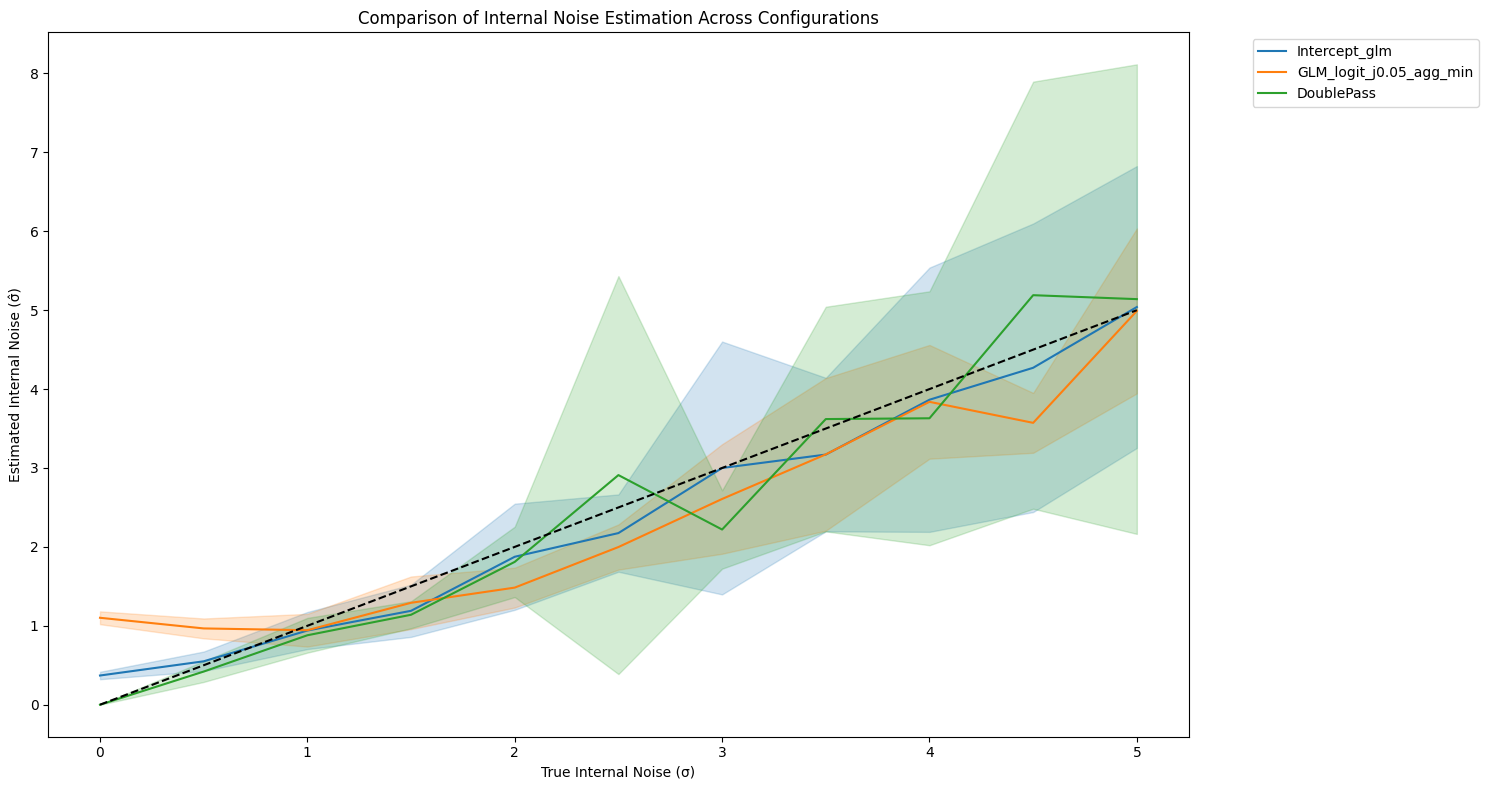

In [ ]:
plt.figure(figsize=(15, 8))
sns.lineplot(
    data=sim_df_all[sim_df_all.config.isin([ 'Intercept_glm', 'DoublePass',  'GLM_logit_j0.05_agg_min'])],
    x="internal_noise_std",
    y="estimated_internal_noise",
    hue="config",
    ci='sd',
    estimator='mean'
)
plt.plot([0, 5], [0, 5], 'k--')
plt.xlabel("True Internal Noise (σ)")
plt.ylabel("Estimated Internal Noise (σ̂)")
plt.title("Comparison of Internal Noise Estimation Across Configurations")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [120]:
InterceptMethod.build_model(agreement_model_file = './intercept_poly5.csv',
                            internal_noise_range=np.arange(0,5,.1),
                            criteria_range=np.arange(-5,5,1),
                            n_repeated_trials=1000, 
                            n_runs=10, 
                            fit_method='poly',bin_data=False, kernel_extractor=ClassificationImage)

InterceptMethod.build_model(agreement_model_file = './intercept_glm5.csv',
                            internal_noise_range=np.arange(0,5,.1),
                            criteria_range=np.arange(-5,5,1),
                            n_repeated_trials=1000, 
                            n_runs=10, 
                            fit_method='glm',bin_data=False, kernel_extractor=ClassificationImage)

DistanceMethod.build_model(agreement_model_file = './distance_weight5.csv',
                            internal_noise_range=np.arange(0,5,.1),
                            criteria_range=np.arange(-5,5,1),
                            n_repeated_trials=1000, 
                            n_runs=10, 
                            weight_trials=True,trial_mask='all',method='accuracy', kernel_extractor=ClassificationImage)

DistanceMethod.build_model(agreement_model_file = './distance_nweight5.csv',
                            internal_noise_range=np.arange(0,5,.1),
                            criteria_range=np.arange(-5,5,1),
                            n_repeated_trials=1000, 
                            n_runs=10, 
                            weight_trials=False,trial_mask='all',method='accuracy', kernel_extractor=ClassificationImage)
                    
DoublePass.build_model(agreement_model_file='dbl_pass5.csv',
                       internal_noise_range=np.arange(0,5,.1),
                            criteria_range=np.arange(-5,5,1),
                            n_repeated_trials=1000, 
                            n_runs=10)

Building agreement model


100%|██████████| 5000/5000 [15:42<00:00,  5.30it/s]


Building agreement model


100%|██████████| 5000/5000 [17:22<00:00,  4.79it/s]


Building agreement model


100%|██████████| 5000/5000 [17:40<00:00,  4.71it/s]


Building agreement model


100%|██████████| 5000/5000 [17:48<00:00,  4.68it/s]


Building agreement model


100%|██████████| 5000/5000 [18:25<00:00,  4.52it/s]


prob_agree  prob_first
internal_noise_std criteria                        
0.0                -5            1.0000     0.99980
                   -4            1.0000     0.99710
                   -3            1.0000     0.98460
                   -2            1.0000     0.91980
                   -1            1.0000     0.75440
...                                 ...         ...
4.9                 0            0.5327     0.49715
                    1            0.5254     0.42370
                    2            0.5613     0.34895
                    3            0.6242     0.27950
                    4            0.6805     0.21125

[500 rows x 2 columns]

In [121]:
observer_params = {'kernel':['random'],
                   'internal_noise_std':np.arange(0,5.1,0.5), 
                  'criteria':[0]}
simple_experiment_params = {'n_trials':[1000],
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [100]}

dp_experiment_params = {'n_trials':[500],
                     'n_repeated':[500],
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [100]}

# Intercept
analyser_params_intercept = {'internal_noise_extractor':[InterceptMethod],
                   'agreement_model_file':['intercept_poly5.csv','intercept_glm5.csv'],
                   'fit_method':['poly','glm'],
                   'bin_data':[False],
                   'kernel_extractor':[ClassificationImage]}
sim = Sim(SimpleExperiment, simple_experiment_params, 
          LinearObserver, observer_params, 
          InternalNoiseValue, analyser_params_intercept)
intercept_sim_df5 = sim.run_all(n_runs=10)

# Distance
analyser_params_distance = {'internal_noise_extractor':[DistanceMethod],
                   'agreement_model_file':['distance_weight5.csv','distance_nweight5.csv'],
                   'kernel_extractor':[ClassificationImage],
                   'weight_trials':[True,False],
                   'trial_mask':['all'], 
                  'method':['accuracy']}
sim = Sim(SimpleExperiment, simple_experiment_params, 
          LinearObserver, observer_params, 
          InternalNoiseValue, analyser_params_distance)
distance_sim_df5 = sim.run_all(n_runs=10)

# GLM
analyser_params_glm = {'internal_noise_extractor':[GLMMethod],
                   'backend':['python'],
                  'link':['logit','probit'],'jitter':[0.02, 0.05, 0.1, 0.15],
                   'agg_mode':['min','argmax']}
sim = Sim(SimpleExperiment, simple_experiment_params, 
          LinearObserver, observer_params, 
          InternalNoiseValue, analyser_params_glm)
glm_sim_df5 = sim.run_all(n_runs=10)

# DoublePass
analyser_params = {'internal_noise_extractor':[DoublePass],
                   'agreement_model_file':['dbl_pass5.csv']}
sim = Sim(DoublePassExperiment, dp_experiment_params, 
          LinearObserver, observer_params, 
          InternalNoiseValue, analyser_params)
dbl_sim_df5 = sim.run_all(n_runs=10)
   
sim_df5 = pd.concat([intercept_sim_df5,distance_sim_df5,glm_sim_df5,dbl_sim_df5])

sim_df5.to_csv('3method_sim8.csv')

100%|██████████| 110/110 [00:12<00:00,  8.97it/s]


In [122]:
sim_df_all5 =pd.read_csv('3method_sim8.csv', index_col=0)
sim_df_all5

,config,n_trials,trial_type,n_features,external_noise_std,kernel,internal_noise_std,criteria,internal_noise_extractor,agreement_model_file,...,run,estimated_internal_noise,weight_trials,trial_mask,method,backend,link,jitter,agg_mode,n_repeated
0,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.internal_noise.intercept_method....,intercept_poly5.csv,...,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.internal_noise.intercept_method....,intercept_poly5.csv,...,5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.internal_noise.intercept_method....,intercept_poly5.csv,...,3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.internal_noise.intercept_method....,intercept_poly5.csv,...,9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.internal_noise.intercept_method....,intercept_poly5.csv,...,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,10,500,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,5.0,0,<class 'palin.internal_noise.double_pass.Doubl...,dbl_pass5.csv,...,9,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0
106,10,500,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,5.0,0,<class 'palin.internal_noise.double_pass.Doubl...,dbl_pass5.csv,...,8,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0
107,10,500,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,5.0,0,<class 'palin.internal_noise.double_pass.Doubl...,dbl_pass5.csv,...,7,4.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0
108,10,500,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,5.0,0,<class 'palin.internal_noise.double_pass.Doubl...,dbl_pass5.csv,...,6,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0


In [123]:
def summarize_config(row):
    method_class = str(row['internal_noise_extractor']).split('.')[-1].replace("'>", "")
    
    if method_class == 'GLMMethod':
        return f"GLM_{row.get('link')}_j{row.get('jitter')}_agg_{row.get('agg_mode')}"
    elif method_class == 'DistanceMethod':
        return f"Distance_weighted_{row.get('weight_trials')}"
    elif method_class == 'InterceptMethod':
        return f"Intercept_{row.get('fit_method')}"
    elif method_class == 'DoublePass':
        return "DoublePass"
    else:
        return method_class

sim_df_all5['config'] = sim_df_all5.apply(summarize_config, axis=1)
sim_df_all5

,config,n_trials,trial_type,n_features,external_noise_std,kernel,internal_noise_std,criteria,internal_noise_extractor,agreement_model_file,...,run,estimated_internal_noise,weight_trials,trial_mask,method,backend,link,jitter,agg_mode,n_repeated
0,Intercept_poly,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.internal_noise.intercept_method....,intercept_poly5.csv,...,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Intercept_poly,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.internal_noise.intercept_method....,intercept_poly5.csv,...,5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Intercept_poly,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.internal_noise.intercept_method....,intercept_poly5.csv,...,3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Intercept_poly,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.internal_noise.intercept_method....,intercept_poly5.csv,...,9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Intercept_poly,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.internal_noise.intercept_method....,intercept_poly5.csv,...,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,DoublePass,500,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,5.0,0,<class 'palin.internal_noise.double_pass.Doubl...,dbl_pass5.csv,...,9,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0
106,DoublePass,500,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,5.0,0,<class 'palin.internal_noise.double_pass.Doubl...,dbl_pass5.csv,...,8,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0
107,DoublePass,500,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,5.0,0,<class 'palin.internal_noise.double_pass.Doubl...,dbl_pass5.csv,...,7,4.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0
108,DoublePass,500,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,5.0,0,<class 'palin.internal_noise.double_pass.Doubl...,dbl_pass5.csv,...,6,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0


In [124]:
sim_df_all5.config.unique()

array(['Intercept_poly', 'Intercept_glm', 'Distance_weighted_True',
       'Distance_weighted_False', 'GLM_logit_j0.02_agg_argmax',
       'GLM_logit_j0.02_agg_min', 'GLM_logit_j0.05_agg_min',
       'GLM_logit_j0.05_agg_argmax', 'GLM_logit_j0.1_agg_min',
       'GLM_logit_j0.1_agg_argmax', 'GLM_logit_j0.15_agg_min',
       'GLM_logit_j0.15_agg_argmax', 'GLM_probit_j0.02_agg_min',
       'GLM_probit_j0.02_agg_argmax', 'GLM_probit_j0.05_agg_min',
       'GLM_probit_j0.05_agg_argmax', 'GLM_probit_j0.1_agg_min',
       'GLM_probit_j0.1_agg_argmax', 'GLM_probit_j0.15_agg_min',
       'GLM_probit_j0.15_agg_argmax', 'DoublePass'], dtype=object)

In [125]:
sim_df_all5['squared_error'] = (sim_df_all5['estimated_internal_noise'] - sim_df_all5['internal_noise_std'])**2

rmse_data_all5 = sim_df_all5.groupby('config', as_index=False).agg(
    rmse=('squared_error', lambda x: np.sqrt(x.mean()))
).sort_values('rmse').reset_index(drop=True)
rmse_data_all5

,config,rmse
0,Intercept_poly,0.634894
1,Intercept_glm,0.748969
2,GLM_logit_j0.02_agg_min,0.812057
3,GLM_probit_j0.05_agg_argmax,0.818086
4,GLM_logit_j0.1_agg_min,0.831614
5,GLM_logit_j0.1_agg_argmax,0.857016
6,DoublePass,0.881270
7,GLM_probit_j0.05_agg_min,0.920478
8,GLM_logit_j0.05_agg_argmax,0.923067
9,GLM_logit_j0.02_agg_argmax,0.933339


G:\Utilisateurs\aynaz.adlzarrabi\AppData\Local\Temp\ipykernel_20900\2560355214.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


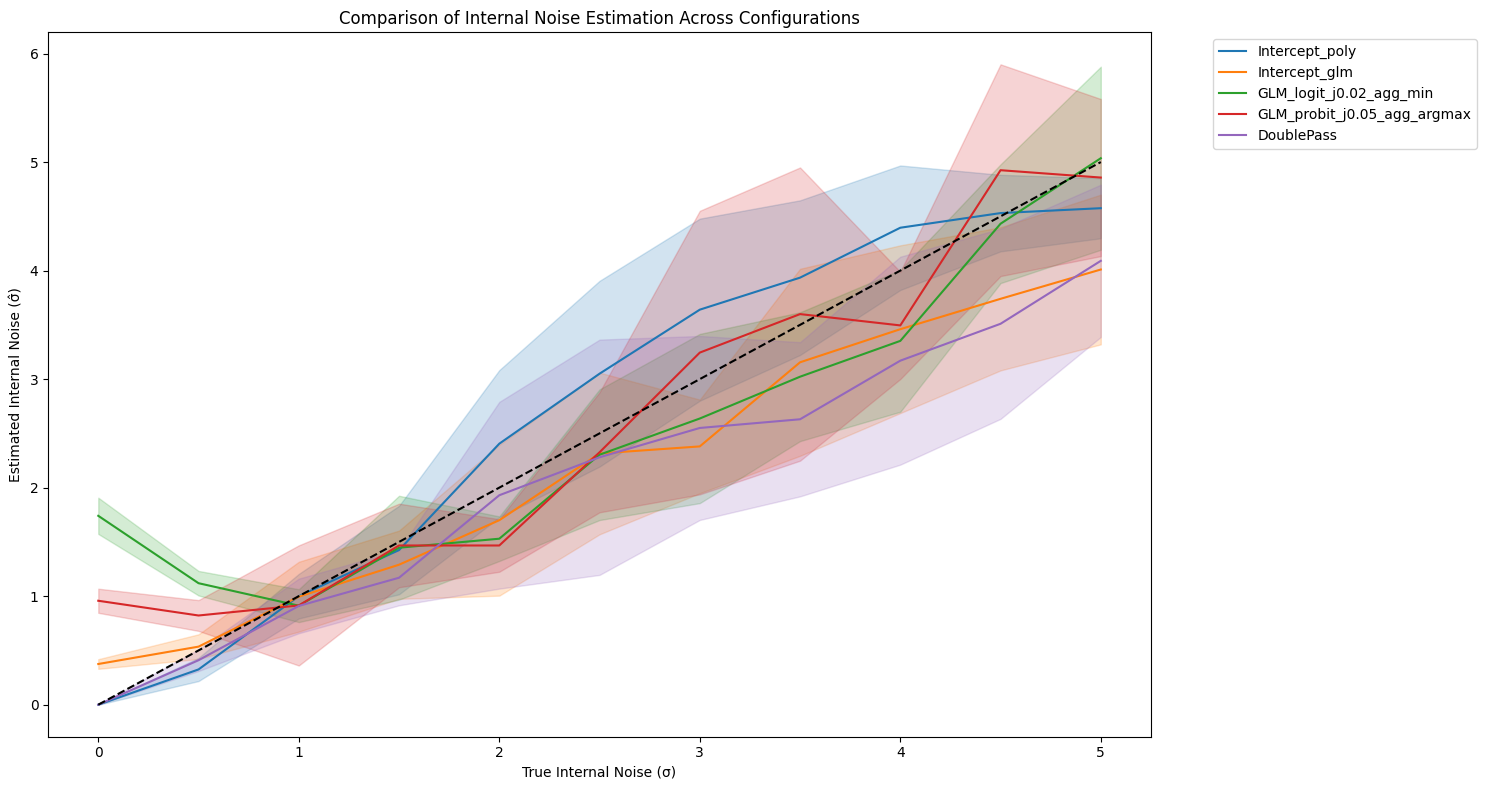

In [128]:
plt.figure(figsize=(15, 8))
sns.lineplot(
    data=sim_df_all5[sim_df_all5.config.isin([ 'Intercept_poly','Intercept_glm', 'DoublePass',  'GLM_logit_j0.02_agg_min',"GLM_probit_j0.05_agg_argmax"])],
    x="internal_noise_std",
    y="estimated_internal_noise",
    hue="config",
    ci='sd',
    estimator='mean'
)
plt.plot([0, 5], [0, 5], 'k--')
plt.xlabel("True Internal Noise (σ)")
plt.ylabel("Estimated Internal Noise (σ̂)")
plt.title("Comparison of Internal Noise Estimation Across Configurations")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()